##Dataset Loading and Pre-Processing

In [1]:
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/mohamedmaher5/vehicle-classification
!unzip -q archive.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  826M  100  826M    0     0  69.0M      0  0:00:11  0:00:11 --:--:-- 60.9M


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import warnings
warnings.filterwarnings("ignore")

data_dir = "/content/Vehicles"

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [4]:
dataset.classes

['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']

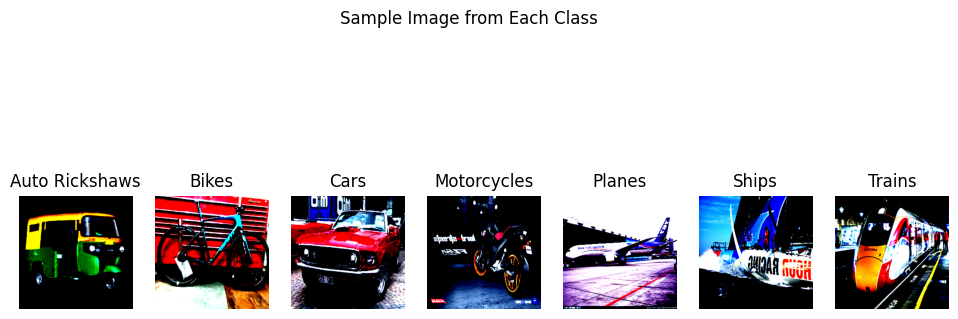

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
class_names = dataset.classes
# Display the image from each class
for class_idx, class_name in enumerate(class_names):

    first_image_idx = next(i for i, label in enumerate(dataset.targets) if label == class_idx)

    img, label = dataset[first_image_idx]
    plt.subplot(1, len(class_names), class_idx + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(class_name)

plt.suptitle("Sample Image from Each Class")
plt.show()


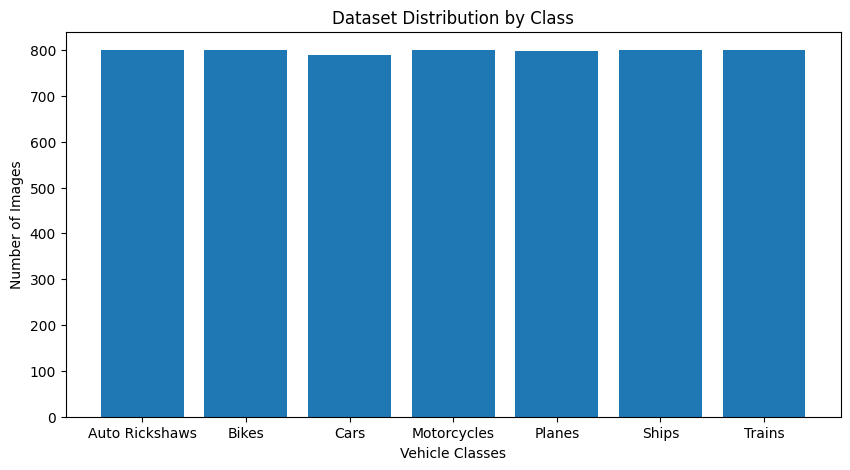

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count images in each class
class_counts = Counter([label for _, label in dataset])
class_names = dataset.classes
class_images = [class_counts[i] for i in range(len(class_names))]

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_images)
plt.xlabel("Vehicle Classes")
plt.ylabel("Number of Images")
plt.title("Dataset Distribution by Class")
plt.show()


In [6]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


##CNN Model Building From Scratch and Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv5(x))

        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv7(x))

        x = F.relu(self.conv8(x))

        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = SimpleCNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

cuda
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [ ]:
train_losses = []
test_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Testing phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {test_accuracies[-1]:.2f}%")

print("Training complete!")


Epoch [1/20], Train Loss: 1.7295, Test Loss: 1.4751, Accuracy: 43.65%
Epoch [2/20], Train Loss: 1.1902, Test Loss: 1.2801, Accuracy: 57.87%
Epoch [3/20], Train Loss: 0.9351, Test Loss: 1.0127, Accuracy: 63.33%
Epoch [4/20], Train Loss: 0.7700, Test Loss: 0.8460, Accuracy: 71.20%
Epoch [5/20], Train Loss: 0.6507, Test Loss: 0.7655, Accuracy: 72.54%
Epoch [6/20], Train Loss: 0.5787, Test Loss: 0.7421, Accuracy: 74.15%
Epoch [7/20], Train Loss: 0.5105, Test Loss: 0.6331, Accuracy: 78.89%
Epoch [8/20], Train Loss: 0.4245, Test Loss: 0.6600, Accuracy: 78.71%
Epoch [9/20], Train Loss: 0.3677, Test Loss: 0.7239, Accuracy: 77.01%
Epoch [10/20], Train Loss: 0.3393, Test Loss: 0.6135, Accuracy: 79.96%
Epoch [11/20], Train Loss: 0.2968, Test Loss: 0.6152, Accuracy: 79.70%
Epoch [12/20], Train Loss: 0.2793, Test Loss: 0.5900, Accuracy: 82.74%
Epoch [13/20], Train Loss: 0.2001, Test Loss: 0.6457, Accuracy: 81.75%
Epoch [14/20], Train Loss: 0.1990, Test Loss: 0.7177, Accuracy: 80.50%
Epoch [15/20], 

In [ ]:
# Save the model
torch.save(model.state_dict(), "vehicle_classification_model.pth")

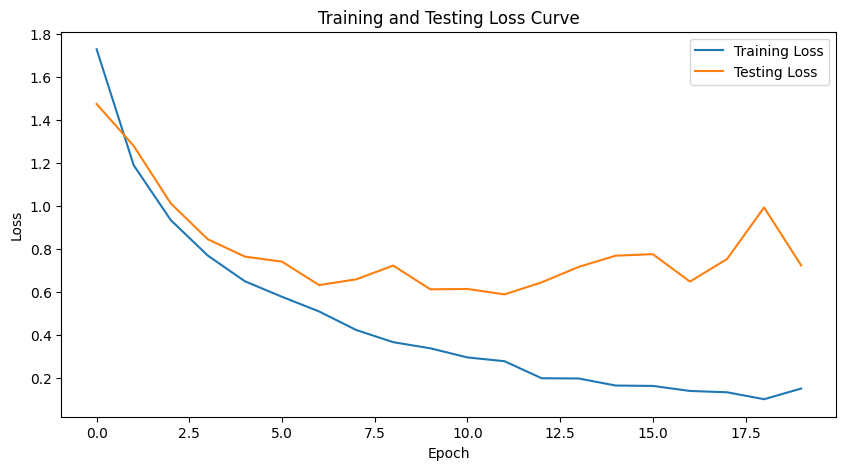

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Curve")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
report = classification_report(all_labels, all_predictions, target_names=dataset.classes)

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1-Score: {f1:.2f}")
print("\nClassification Report:\n", report)


Accuracy: 0.82
Weighted Precision: 0.82
Weighted Recall: 0.82
Weighted F1-Score: 0.82

Classification Report:
                 precision    recall  f1-score   support

Auto Rickshaws       0.78      0.82      0.80       160
         Bikes       0.95      0.93      0.94       155
          Cars       0.75      0.79      0.77       156
   Motorcycles       0.82      0.86      0.84       186
        Planes       0.82      0.77      0.79       166
         Ships       0.86      0.75      0.80       157
        Trains       0.80      0.83      0.81       138

      accuracy                           0.82      1118
     macro avg       0.82      0.82      0.82      1118
  weighted avg       0.82      0.82      0.82      1118



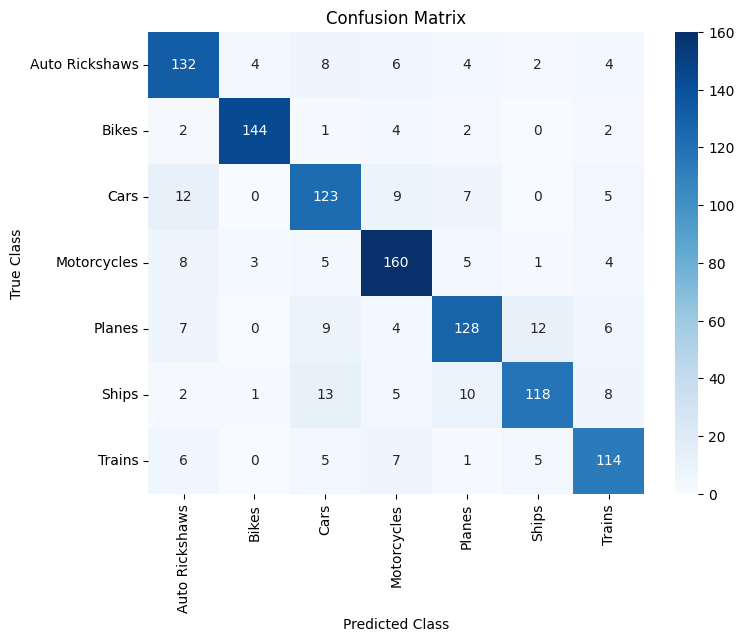

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Base Model Confusion Matrix")
plt.show()

## ResNet-18 Model Training with Hyperparameter Tunning

In [7]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset_new, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader_new = DataLoader(train_dataset_new, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

num_classes = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [11]:
import torch.optim as optim
# Define a list of hyperparameters to test
hyperparameters = [
    {'optimizer': optim.Adam, 'lr': 0.001, 'weight_decay': 0.0001},
    {'optimizer': optim.Adam, 'lr': 0.0001, 'weight_decay': 0.001},
    {'optimizer': optim.SGD, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001},
    {'optimizer': optim.SGD, 'lr': 0.005, 'momentum': 0.9, 'weight_decay': 0.0001},
    {'optimizer': optim.Adam, 'lr': 0.01, 'weight_decay': 0.0001},
    {'optimizer': optim.SGD, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001},
]


In [ ]:
# Lists to store metrics for each model (by hyperparameter configuration)
all_train_losses = {}
all_val_losses = {}
all_train_accuracies = {}
all_val_accuracies = {}

best_val_accuracy = 0
best_params = None

# Loop through hyperparameter options
for idx, params in enumerate(hyperparameters):
    resnet_model = models.resnet18(pretrained=False)
    resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
    resnet_model = resnet_model.to(device)

    optimizer = params['optimizer'](resnet_model.parameters(), lr=params['lr'], \
                                    **{k: v for k, v in params.items() if k not in ['optimizer', 'lr']})
    criterion = nn.CrossEntropyLoss()

    # Temporary lists to store each model's metrics
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(15):
        resnet_model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training loop
        for images, labels in train_loader_new:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader_new)
        train_accuracy = 100 * correct / total

        # Validation loop
        resnet_model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = resnet_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total

        # Append to temporary lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Model {idx+1} - Epoch [{epoch+1}/15], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

        # Track best parameters based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = params

    # Store metrics for the current model
    all_train_losses[f"Model {idx+1}"] = train_losses
    all_val_losses[f"Model {idx+1}"] = val_losses
    all_train_accuracies[f"Model {idx+1}"] = train_accuracies
    all_val_accuracies[f"Model {idx+1}"] = val_accuracies

print("Best Hyperparameters:", best_params)


Model 1 - Epoch [1/15], Train Loss: 1.2988, Val Loss: 1.3923, Train Acc: 53.24%, Val Acc: 57.32%
Model 1 - Epoch [2/15], Train Loss: 0.8996, Val Loss: 0.9831, Train Acc: 68.29%, Val Acc: 65.92%
Model 1 - Epoch [3/15], Train Loss: 0.7254, Val Loss: 0.7640, Train Acc: 74.44%, Val Acc: 71.51%
Model 1 - Epoch [4/15], Train Loss: 0.6278, Val Loss: 0.8680, Train Acc: 78.38%, Val Acc: 69.27%
Model 1 - Epoch [5/15], Train Loss: 0.5550, Val Loss: 0.6910, Train Acc: 80.31%, Val Acc: 76.98%
Model 1 - Epoch [6/15], Train Loss: 0.5134, Val Loss: 0.6009, Train Acc: 82.02%, Val Acc: 78.99%
Model 1 - Epoch [7/15], Train Loss: 0.4559, Val Loss: 0.4806, Train Acc: 84.17%, Val Acc: 83.69%
Model 1 - Epoch [8/15], Train Loss: 0.4027, Val Loss: 0.4744, Train Acc: 85.79%, Val Acc: 83.91%
Model 1 - Epoch [9/15], Train Loss: 0.3572, Val Loss: 0.6346, Train Acc: 87.61%, Val Acc: 79.22%
Model 1 - Epoch [10/15], Train Loss: 0.3476, Val Loss: 0.5823, Train Acc: 88.34%, Val Acc: 80.22%
Model 1 - Epoch [11/15], Trai

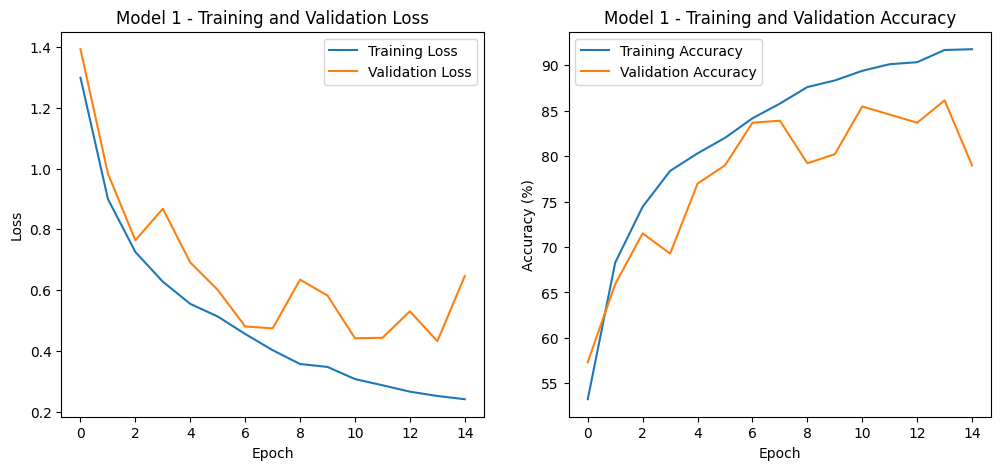

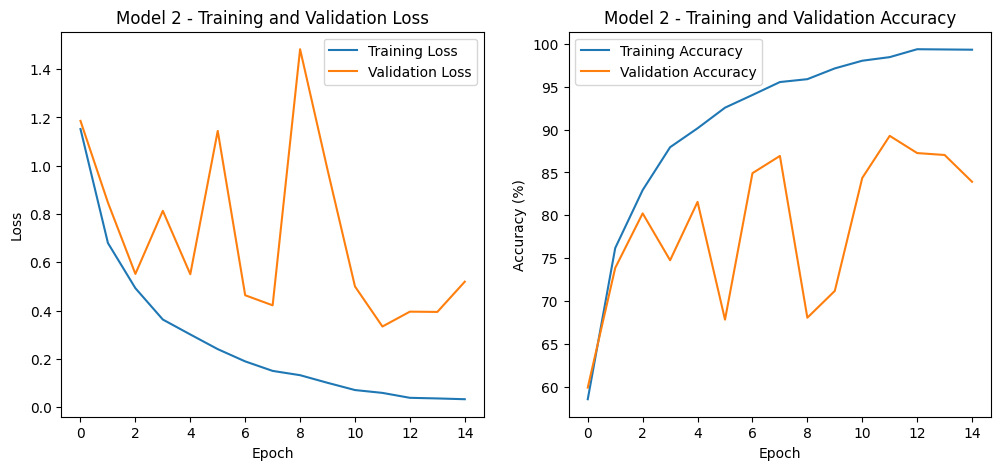

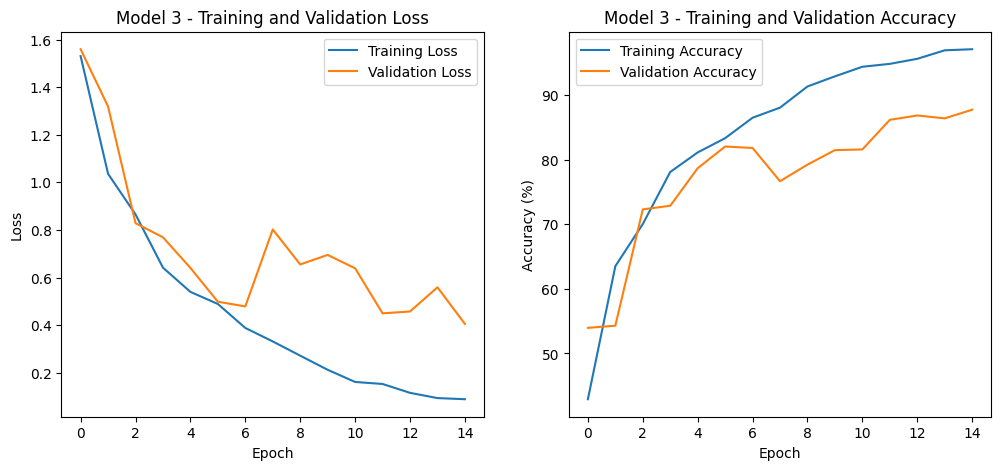

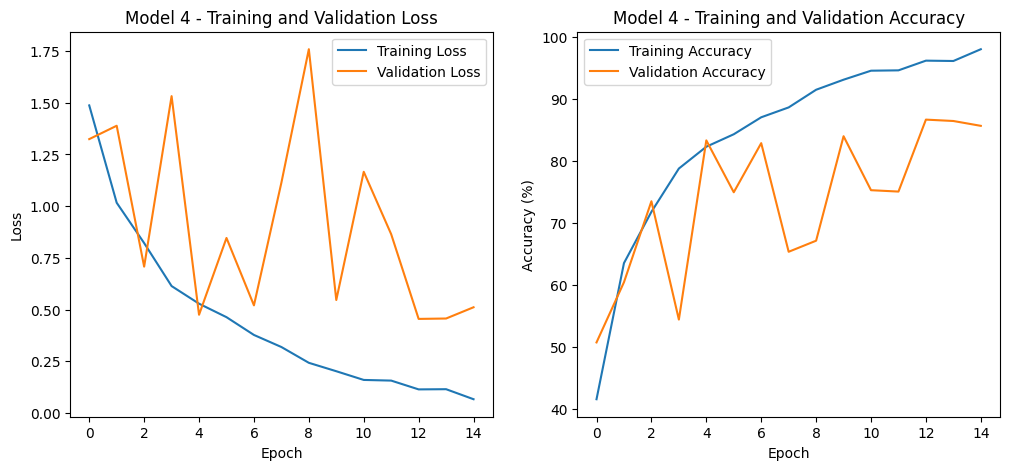

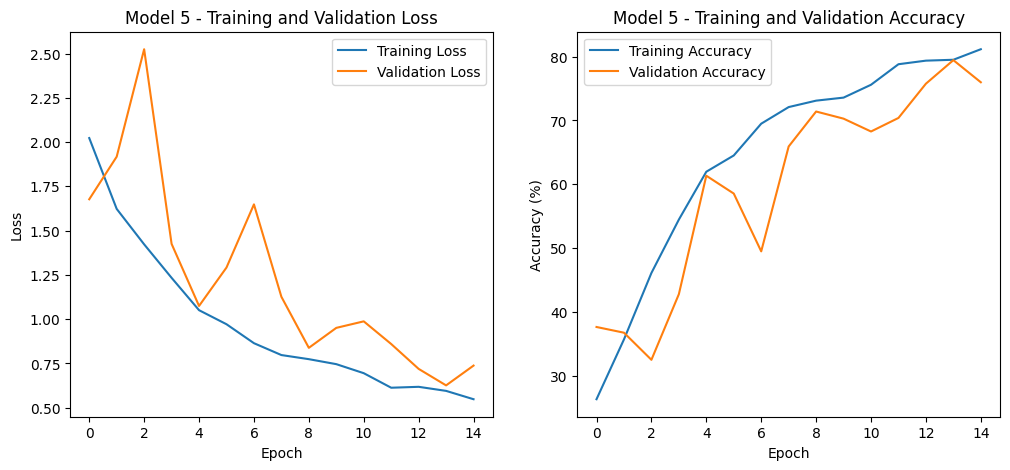

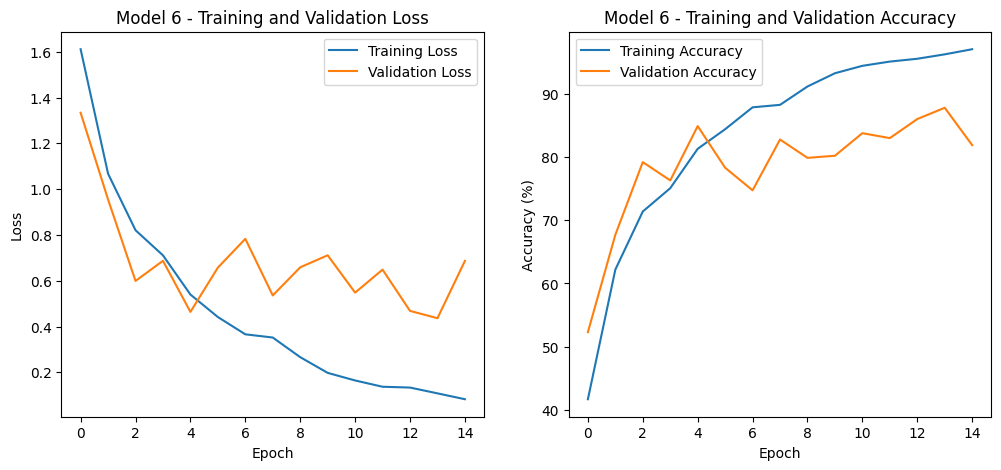

In [ ]:
import matplotlib.pyplot as plt

for model_name in all_train_losses.keys():
    plt.figure(figsize=(12, 5))

    # Training and Validation Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(all_train_losses[model_name], label="Training Loss")
    plt.plot(all_val_losses[model_name], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Training and Validation Loss")
    plt.legend()

    # Training and Validation Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(all_train_accuracies[model_name], label="Training Accuracy")
    plt.plot(all_val_accuracies[model_name], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{model_name} - Training and Validation Accuracy")
    plt.legend()

    plt.show()


##Choosing Best parameters and Training ResNet-18 on those parameters with Training and Testing Dataset

In [ ]:
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'lr': 0.0001, 'weight_decay': 0.001}


In [21]:
resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet_model.parameters(), lr=0.0001, weight_decay=0.001)

# Lists to store metrics for plotting
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

# Training and Testing Loop
num_epochs = 120
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training Loop
    for images, labels in full_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(full_train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Test Phase
    resnet_model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
          f"Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")


Epoch [1/120], Train Loss: 2.0165, Test Loss: 1.9585, Train Acc: 17.94%, Test Acc: 22.90%
Epoch [2/120], Train Loss: 1.9372, Test Loss: 1.9097, Train Acc: 21.72%, Test Acc: 24.78%
Epoch [3/120], Train Loss: 1.8971, Test Loss: 1.8797, Train Acc: 24.25%, Test Acc: 26.92%
Epoch [4/120], Train Loss: 1.8719, Test Loss: 1.8625, Train Acc: 25.48%, Test Acc: 28.98%
Epoch [5/120], Train Loss: 1.8543, Test Loss: 1.8435, Train Acc: 27.09%, Test Acc: 27.82%
Epoch [6/120], Train Loss: 1.8371, Test Loss: 1.8269, Train Acc: 28.92%, Test Acc: 30.86%
Epoch [7/120], Train Loss: 1.8197, Test Loss: 1.8104, Train Acc: 31.22%, Test Acc: 30.77%
Epoch [8/120], Train Loss: 1.8055, Test Loss: 1.7947, Train Acc: 32.57%, Test Acc: 33.36%
Epoch [9/120], Train Loss: 1.7891, Test Loss: 1.7779, Train Acc: 33.44%, Test Acc: 32.20%
Epoch [10/120], Train Loss: 1.7745, Test Loss: 1.7619, Train Acc: 34.87%, Test Acc: 35.78%
Epoch [11/120], Train Loss: 1.7609, Test Loss: 1.7430, Train Acc: 35.45%, Test Acc: 36.76%
Epoch [1

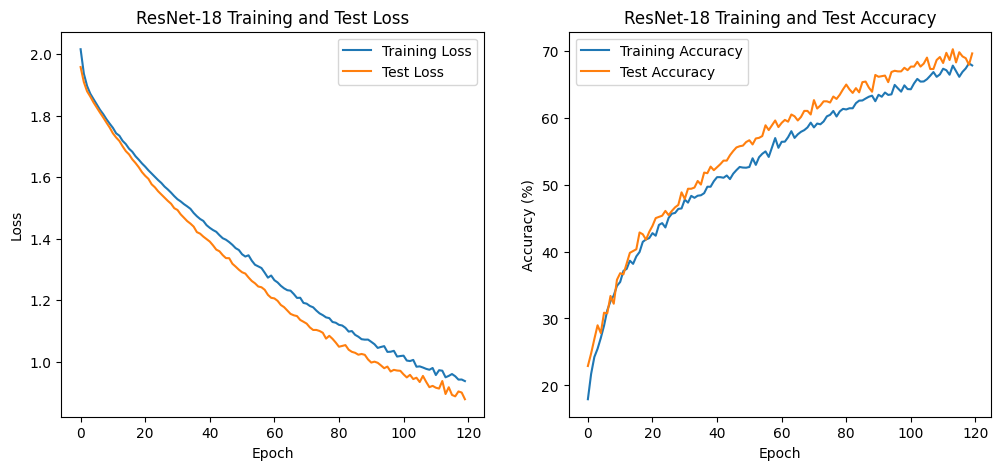

In [22]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss/Accuracy Curves
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet-18 Training and Test Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("ResNet-18 Training and Test Accuracy")
plt.legend()

plt.show()


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
report = classification_report(all_labels, all_predictions, target_names=dataset.classes)

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1-Score: {f1:.2f}")
print("\nClassification Report:\n", report)


Accuracy: 0.70
Weighted Precision: 0.70
Weighted Recall: 0.70
Weighted F1-Score: 0.70

Classification Report:
                 precision    recall  f1-score   support

Auto Rickshaws       0.61      0.70      0.65       153
         Bikes       0.81      0.87      0.84       163
          Cars       0.62      0.42      0.50       159
   Motorcycles       0.75      0.82      0.78       162
        Planes       0.70      0.81      0.75       154
         Ships       0.78      0.73      0.76       176
        Trains       0.60      0.56      0.58       151

      accuracy                           0.70      1118
     macro avg       0.70      0.70      0.69      1118
  weighted avg       0.70      0.70      0.70      1118



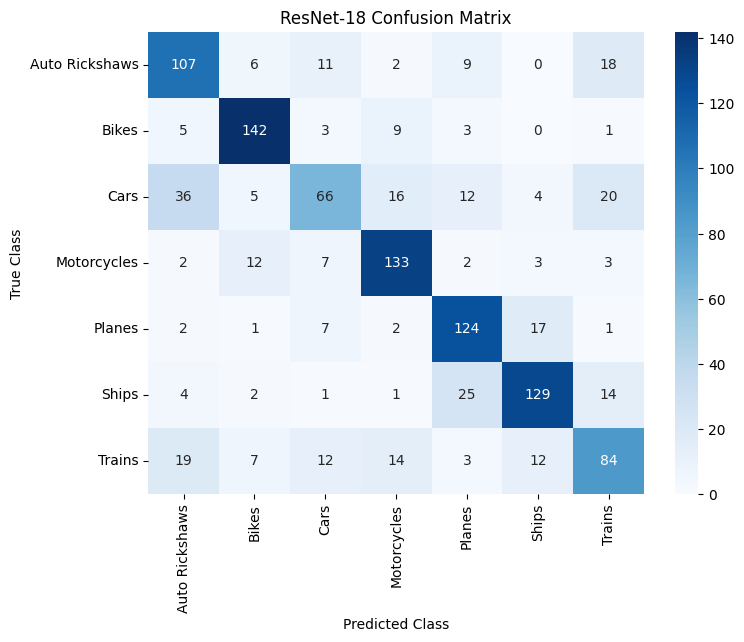

In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("ResNet-18 Confusion Matrix")
plt.show()

## Mobilenet V2 Model Training and Testing

In [16]:
# Initialize MobileNetV2 model without pre-trained weights
mobilenet_model = models.mobilenet_v2(pretrained=False)
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.classifier[1].in_features, len(dataset.classes))
mobilenet_model = mobilenet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobilenet_model.parameters(), lr=0.001, weight_decay=0.001)

In [17]:
# Set up model, optimizer, and criterion before running this code block
num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    mobilenet_model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    mobilenet_model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")


Epoch [1/30], Train Loss: 1.9423, Test Loss: 1.9083, Train Acc: 16.73%, Test Acc: 21.65%
Epoch [2/30], Train Loss: 1.8930, Test Loss: 1.8555, Train Acc: 22.55%, Test Acc: 28.26%
Epoch [3/30], Train Loss: 1.8483, Test Loss: 1.7966, Train Acc: 26.21%, Test Acc: 29.52%
Epoch [4/30], Train Loss: 1.7844, Test Loss: 1.7281, Train Acc: 28.09%, Test Acc: 32.29%
Epoch [5/30], Train Loss: 1.7208, Test Loss: 1.6596, Train Acc: 31.49%, Test Acc: 36.40%
Epoch [6/30], Train Loss: 1.6467, Test Loss: 1.5935, Train Acc: 33.21%, Test Acc: 37.57%
Epoch [7/30], Train Loss: 1.5819, Test Loss: 1.5187, Train Acc: 37.13%, Test Acc: 41.23%
Epoch [8/30], Train Loss: 1.5242, Test Loss: 1.4310, Train Acc: 39.14%, Test Acc: 42.75%
Epoch [9/30], Train Loss: 1.4511, Test Loss: 1.3873, Train Acc: 43.68%, Test Acc: 47.50%
Epoch [10/30], Train Loss: 1.3917, Test Loss: 1.3114, Train Acc: 46.50%, Test Acc: 51.61%
Epoch [11/30], Train Loss: 1.3337, Test Loss: 1.3256, Train Acc: 49.61%, Test Acc: 48.93%
Epoch [12/30], Trai

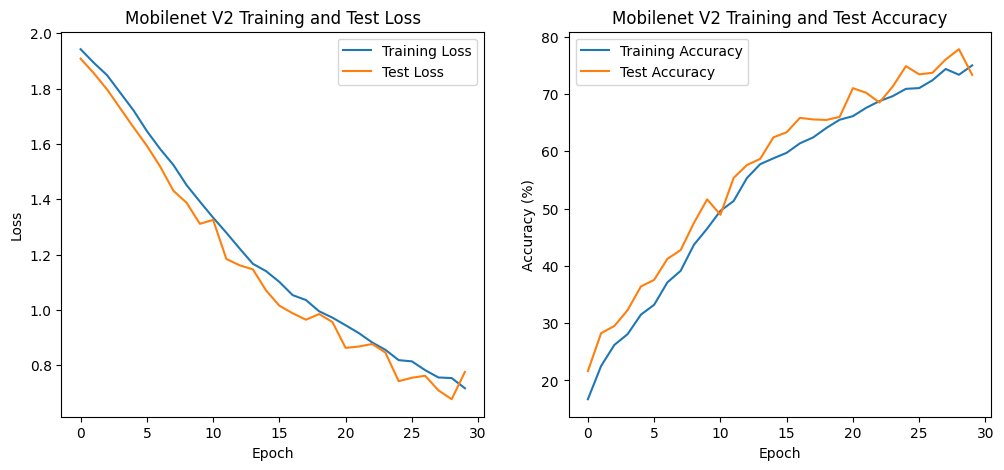

In [19]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Training and validation loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mobilenet V2 Training and Test Loss")
plt.legend()

# Training and validation accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Mobilenet V2 Training and Test Accuracy")
plt.legend()

plt.show()

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
report = classification_report(all_labels, all_predictions, target_names=dataset.classes)

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1-Score: {f1:.2f}")
print("\nClassification Report:\n", report)


Accuracy: 0.74
Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-Score: 0.74

Classification Report:
                 precision    recall  f1-score   support

Auto Rickshaws       0.73      0.74      0.73       152
         Bikes       0.85      0.93      0.89       144
          Cars       0.64      0.51      0.57       164
   Motorcycles       0.70      0.88      0.78       172
        Planes       0.83      0.70      0.76       159
         Ships       0.86      0.69      0.77       171
        Trains       0.61      0.74      0.67       156

      accuracy                           0.74      1118
     macro avg       0.75      0.74      0.74      1118
  weighted avg       0.74      0.74      0.74      1118



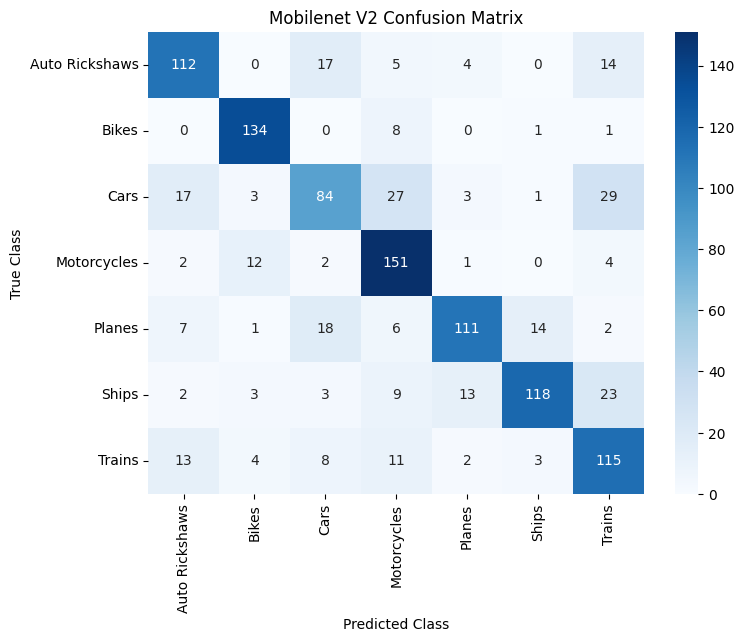

In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Mobilenet V2 Confusion Matrix")
plt.show()